In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
# from transformers import AutoImageProcessor, ResNetForImageClassification,ResNetConfig
import torch
from abc import ABC,abstractmethod

In [2]:
#TODO check if layers are actually being trained
#TODO add more models
#TODO compare metrics
#TODO test out prediction loop
#TODO learn how to use tensorboard

#TODO week2 Balance Dataset
#TODO day2 Implement checkpointing and checkpoint loading
#TODO day2 implement an actually good and modular pipeline
#TODO day2 EDA + explore augments
#TODO day2 normalize and test out mean/median/std of pixel values
#TODO day2 Actually implement additional layers and finish what i started
#TODO Verify data is sent correctly (esp labels)

#TODO day2 implement localization/segmentation + research more abt osteopenia
#interesting models: yolo v5, medsam

###DATASET PREP###

In [3]:
projectPath = r"Osteoporosis Knee X-ray"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)

In [4]:
from PIL import Image
imageSizes = {}
for x in pathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(1024, 1024)': 63,
 '(2180, 2660)': 61,
 '(2660, 2180)': 10,
 '(2430, 1994)': 94,
 '(2386, 1994)': 1,
 '(1994, 2430)': 2,
 '(2430, 1910)': 2,
 '(2402, 1994)': 1,
 '(2378, 1994)': 2,
 '(2362, 1994)': 1,
 '(2430, 1958)': 1,
 '(2398, 1994)': 1}

In [5]:
labelList.count(0),labelList.count(1),labelList.count(2)

(36, 154, 49)

In [6]:
import torchvision
import torch


class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None):
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx)->tuple[Image.Image,int]:
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        image = Image.open(self.itemsPath[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return torchvision.transforms.functional.pil_to_tensor(image), self.labels[idx]
        
    

transform = torchvision.transforms.Compose([torchvision.transforms.Resize([244,244])
                                            # ,torchvision.transforms.Grayscale()
                                            ])
osteoDataset = OsteoTorchDataset(pathList,labelList,transform)
                                            

In [7]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

train,val = torch.utils.data.random_split(osteoDataset,[0.8,0.2])#MAY BUG
trainSampler = WeightedRandomSampler(weights=[0.4,0.2,0.4],num_samples=len(train),replacement=True)
# valSampler = WeightedRandomSampler(weights=[0.4,0.2,0.4],num_samples=,replacement=True)

trainLoader = DataLoader(train, batch_size = 16,shuffle=False,num_workers=0)
valLoader = DataLoader(val, batch_size = 16,shuffle=False,num_workers=0)

In [69]:
[y for x,y in valLoader]

[tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1]),
 tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2]),
 tensor([2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0])]

In [8]:
# from dataWrapper import DataWrapper
# BUG still dosent work, does not fix the Num_workers issue
# loader = DataWrapper(pathList,labelList, batch_size = 16,shuffle=False,num_workers=15)

In [9]:
# import models here
from models import AlexNet

In [10]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns

#FIXME implement proper instancing to support multiple models
#FIXME identify bottleneck
#FIXME clean up my fucking code ffs its so UGLY

class ExperimentModel(L.LightningModule):
    def __init__(self,pretrainedModel,pretrainedPreprocess,outputSize,resize = False,pretrained = False) -> None:
        super().__init__()
        if type(pretrainedModel) != str:
            print("using model as-is")
            self.model = pretrainedModel
        else:
            self.model = torch.hub.load('pytorch/vision:v0.19.0', pretrainedModel, pretrained=pretrained)
            
        # if pretrainedPreprocess:
        #     self.preprocess = pretrainedPreprocess  
        # for param in self.model.parameters():
        #     param.requires_grad = False
        self.resize = resize

        if self.resize:
            try: 
                self.linear1 = torch.nn.Linear(self.model.fc.out_features, 512)
            except AttributeError:
                print("no fc detected, switcing to provided outputSize")
                self.linear1 = torch.nn.Linear(outputSize, 512)

            self.linear2 = torch.nn.Linear(512, 32)
            self.linear3 = torch.nn.Linear(32, 3) 
            #FIXME add softmax

        self.valLog = []
        self.epoch = []
        self.valPreds = []
        self.valLabels = []
        self.valScore = []

        self.bestValPreds = []
        self.bestValLabels = []
        self.bestValScore = 0
        
    def forward(self,input):
        out = self.model(input)
        if self.resize:
            out = self.linear1(out)
            out = self.linear2(out)
            out = self.linear3(out)
        return out
        
    def training_step(self,batch):
        data,label = batch
        output = self(data.float())
        loss= F.cross_entropy(output,label)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        data,label = batch
        output = self(data.float())
        loss= F.cross_entropy(output,label)
        self.valLabels.append(label)
        self.valPreds.append(output)
        self.valScore.append(multiclass_f1_score(output,label,num_classes=3))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", multiclass_f1_score(output,label,num_classes=3), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", multiclass_accuracy(output,label,num_classes=3), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    def on_validation_epoch_end(self) -> None:
        if len(self.valScore) == 2:
            return None
        
        accuracy = torch.stack(self.valScore).mean()
        # self.log("cust",self.linear3.weight.sum(),logger=True)
        if accuracy > self.bestValScore:
            print("updated best score--------------------------------------------------------")
            self.bestValScore = accuracy
            self.bestValPreds = torch.cat(self.valPreds)
            self.bestValLabels = torch.cat(self.valLabels)

        print(f"\n Validation accuracy: {accuracy}")
        print(f"debug: {len(self.valScore)}")
        print(f"bestValScore: {self.bestValScore}")
        
        self.valPreds = []
        self.valLabels = []
        self.valScore = []

        # confusion_matrix = MulticlassConfusionMatrix(num_classes=3, threshold=0.05)
        # confusion_matrix(y_hat, y.int())

        # confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy().astype(int)

        # df_cm = pd.DataFrame(confusion_matrix_computed)
        # plt.figure(figsize = (10,7))
        # fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        # plt.close(fig_)
        # self.log.experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    def get_self_variables(self):
        linear_variables = [x for x in dir(self) if 'linear' in x]
        return [getattr(self, x, None).parameters() for x in linear_variables]
        

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(),lr=0.001)
        # return torch.optim.AdamW(itertools.chain(self.model.parameters(),*self.get_self_variables()), lr=0.001)
        pass

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

# class ResNetCallbacks(L.Callback): #TODO implement callbacks
#     def on_validation_epoch_end(trainer, pl_module):
#         valLog.append(sum(self.cumLog)/len(self.cumlog))

    
# alexNet = ExperimentModel(AlexNet(num_classes=1000),None,1000,True)
# alexNetNonMod = ExperimentModel(AlexNet(num_classes=3),None,3)
# alexNet = ExperimentModel(AlexNet(num_classes=3),None,3)
resnet50 = ExperimentModel("resnet50",None,1000,resize=True,pretrained=False)
resnet18 = ExperimentModel("resnet18",None,1000,resize=True,pretrained=False)
effnet = ExperimentModel("efficientnet_v2_m",None,1000,resize=True,pretrained=True)
mobilenet = ExperimentModel("mobilenet_v3_large",None,1000,resize=True,pretrained=True)
modelList = [resnet50,resnet18,effnet,mobilenet]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0
Using cache found in C:\Users\assaw/.cache

no fc detected, switcing to provided outputSize
no fc detected, switcing to provided outputSize


Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger



logger = TensorBoardLogger("tb_logs", name="my_model")
# trainer.fit(model=alexNet,train_dataloaders=loader.trainLoader,val_dataloaders=loader.valLoader)
for x in modelList:
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=5,          # Number of epochs with no improvement after which training will be stopped
        verbose=False,        # Verbosity mode
        mode='min'           # Mode can be 'min', 'max', or 'auto'
    )
    trainer = L.Trainer(max_epochs = 5,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
    
    trainer.fit(model=x,train_dataloaders=trainLoader,val_dataloaders=valLoader)

Using 16bit Automatic Mixed Precision (AMP)
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | model   | ResNet | 25.6 M | train
1 | linear1 | Linear | 512 K  | train
2 | linear2 | Linear | 16.4 K | train
3 | linear3 | Linea

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 12/12 [00:08<00:00,  1.33it/s, v_num=1, train_loss_step=0.776]updated best score--------------------------------------------------------

 Validation accuracy: 0.3766666650772095
debug: 5
bestValScore: 0.3766666650772095
Epoch 1: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s, v_num=1, train_loss_step=0.600, val_loss=430.0, val_acc_F1=0.191, val_acc=0.191, train_loss_epoch=3.120]updated best score--------------------------------------------------------

 Validation accuracy: 0.6152777671813965
debug: 3
bestValScore: 0.6152777671813965
Epoch 2: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s, v_num=1, train_loss_step=0.743, val_loss=1.100, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=1.200]
 Validation accuracy: 0.6152777671813965
debug: 3
bestValScore: 0.6152777671813965
Epoch 3: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s, v_num=1, train_loss_step=0.788, val_loss=1.160, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=1.010]
 Validation accuracy: 0.48

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, v_num=1, train_loss_step=0.641, val_loss=0.912, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=0.887]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:652: Checkpoint directory tb_logs\my_model\version_1\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | model   | ResNet | 11.7 M | train
1 | linear1 | Linear | 512 K  | train
2 | linear2 | Linear | 16.4 K | train
3 | linear3 | Linear | 99     | train
-------------------------------------------
12.2 M    Trainable params
0         Non-trainable params
12.2 M    Total params
48.874    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s, v_num=1, train_loss_step=0.648]updated best score--------------------------------------------------------

 Validation accuracy: 0.4566666781902313
debug: 5
bestValScore: 0.4566666781902313
Epoch 1: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, v_num=1, train_loss_step=0.565, val_loss=3.850, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=1.330]updated best score--------------------------------------------------------

 Validation accuracy: 0.6152777671813965
debug: 3
bestValScore: 0.6152777671813965
Epoch 2: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s, v_num=1, train_loss_step=0.580, val_loss=1.100, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=0.928]
 Validation accuracy: 0.6152777671813965
debug: 3
bestValScore: 0.6152777671813965
Epoch 3: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, v_num=1, train_loss_step=0.643, val_loss=0.984, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=0.910]
 Validation accuracy: 0.61

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s, v_num=1, train_loss_step=0.606, val_loss=0.976, val_acc_F1=0.596, val_acc=0.596, train_loss_epoch=0.833]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | EfficientNet | 54.1 M | train
1 | linear1 | Linear       | 512 K  | train
2 | linear2 | Linear       | 16.4 K | train
3 | linear3 | Linear       | 99     | train
-------------------------------------------------
54.7 M    Trainable params
0         Non-trainable params
54.7 M    Total params
218.674   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1, train_loss_step=1.030]updated best score--------------------------------------------------------

 Validation accuracy: 0.27916666865348816
debug: 5
bestValScore: 0.27916666865348816
Epoch 1: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, v_num=1, train_loss_step=0.623, val_loss=1.170, val_acc_F1=0.277, val_acc=0.277, train_loss_epoch=1.340]updated best score--------------------------------------------------------

 Validation accuracy: 0.6152777671813965
debug: 3
bestValScore: 0.6152777671813965
Epoch 2: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1, train_loss_step=0.630, val_loss=0.965, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=0.957]
 Validation accuracy: 0.6152777671813965
debug: 3
bestValScore: 0.6152777671813965
Epoch 3: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1, train_loss_step=0.514, val_loss=0.940, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=0.938]
 Validation accuracy: 0.

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 12/12 [00:15<00:00,  0.78it/s, v_num=1, train_loss_step=0.666, val_loss=0.911, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=0.899]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | MobileNetV3 | 5.5 M  | train
1 | linear1 | Linear      | 512 K  | train
2 | linear2 | Linear      | 16.4 K | train
3 | linear3 | Linear      | 99     | train
------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.048    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s, v_num=1, train_loss_step=1.410]updated best score--------------------------------------------------------

 Validation accuracy: 0.5316666960716248
debug: 5
bestValScore: 0.5316666960716248
Epoch 1: 100%|██████████| 12/12 [00:08<00:00,  1.42it/s, v_num=1, train_loss_step=1.360, val_loss=1.640, val_acc_F1=0.617, val_acc=0.617, train_loss_epoch=2.420]
 Validation accuracy: 0.3847222328186035
debug: 3
bestValScore: 0.5316666960716248
Epoch 2: 100%|██████████| 12/12 [00:08<00:00,  1.38it/s, v_num=1, train_loss_step=1.290, val_loss=1.260, val_acc_F1=0.383, val_acc=0.383, train_loss_epoch=1.180]
 Validation accuracy: 0.4888889193534851
debug: 3
bestValScore: 0.5316666960716248
Epoch 3: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s, v_num=1, train_loss_step=0.0991, val_loss=1.230, val_acc_F1=0.489, val_acc=0.489, train_loss_epoch=1.260]updated best score--------------------------------------------------------

 Validation accuracy: 0.5

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1, train_loss_step=0.521, val_loss=1.770, val_acc_F1=0.447, val_acc=0.447, train_loss_epoch=0.701]


In [28]:
# raise AssertionError("done")
for x in modelList:
    print(f"model: {x.model.__class__.__name__}")
    print(f"bestValScore: {x.bestValScore}")
    print(f"bestValPreds: {[y.argmax().item() for y in x.bestValPreds]}")
    # print(f"bestValLabels: {x.bestValLabels}")

model: ResNet
bestValScore: 0.6152777671813965
bestValPreds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
model: ResNet
bestValScore: 0.6152777671813965
bestValPreds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
model: EfficientNet
bestValScore: 0.6152777671813965
bestValPreds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
model: MobileNetV3
bestValScore: 0.5500000715255737
bestValPreds: [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]


tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0],
       device='cuda:0')

tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0])
tensor([[0.2222, 0.7778, 0.0000],
        [0.1724, 0.8276, 0.0000],
        [0.1111, 0.8889, 0.0000]])


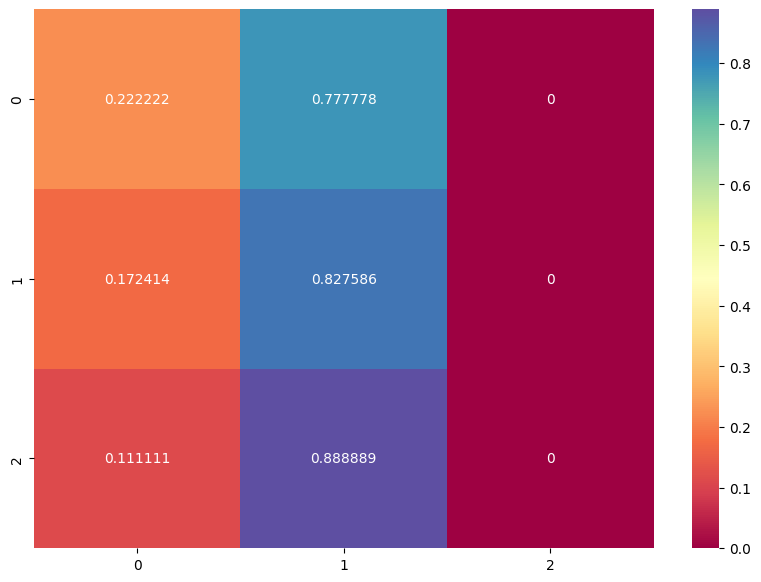

In [65]:
# raise AssertionError("Stop here")
# alex net acc F1 = 0.62 loss = 0.923
# resnet18 acc F1 = ? loss = 1
# resnet50 acc F1 = 0.29 loss = 3
# resnet50 Custom acc F1 = 0.62 loss = 0.957
# resnet50 Custom acc oversampled F1 = 0.78 loss = 0.759
# mobilenet 
# effnet
# Vits 

# model = alexNetNonMod.load_from_checkpoint("/path/to/checkpoint.ckpt")


def testConfMatrix(self) -> None:
        y_hat = torch.tensor([y.argmax() for y in self.bestValPreds]).to('cpu')
        y = self.bestValLabels.to('cpu')

        print(y_hat),print(y)

        confusion_matrix = MulticlassConfusionMatrix(num_classes=3,normalize='true')
        print(confusion_matrix(y_hat, y))

        confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy()

        df_cm = pd.DataFrame(confusion_matrix_computed)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral',fmt='g').get_figure()
        plt.show()
       

testConfMatrix(modelList[3])

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Metric to monitor
#     patience=3,          # Number of epochs with no improvement after which training will be stopped
#     verbose=True,        # Verbosity mode
#     mode='min'           # Mode can be 'min', 'max', or 'auto'
# )

# logger = TensorBoardLogger("tb_logs", name="my_model")
# trainer = L.Trainer(max_epochs = 20,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
# trainer.fit(model=alexNetNonMod,train_dataloaders=trainLoader,val_dataloaders=valLoader

In [51]:
x

ExperimentModel(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivat

In [ ]:
data = []
label = []
valOutput = []
valLabel = []

from itertools import tee
testTrainer =  L.Trainer(accelerator='gpu', devices='auto')
out = testTrainer.predict(alexNet, valLoader)

loader1, loader2 = tee(valLoader)#BUG BUG BUG INCREDIBLY MEMORY INEFFICIENT DONOT RUN THIS ON ANYTHIGN BIGGER THAN 1000 IMAGES

for idx,x in enumerate(valLoader):
    data,label = x
    [valLabel.append(x) for x in label]

valOutput = trainer.predict(alexNet, loader2)

In [ ]:
label